<a href="https://colab.research.google.com/github/ogrogaming/eccdum_assignments/blob/main/Entrega_final_rev_14_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Entrega Final - Estrategia comerciales con datos.**
## Maestría UMPE



---

Miguel Di Landro

Jerónimo Rodríguez

Gabriel López

---


*Correr utilizando "T4 GPU".*



---

#1. Carga de paquetes y librerías:


In [ ]:
# Instalación de paquete:
!pip install -q eccd_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 13.2 MB/s eta 0:00:00


In [ ]:
# Importación de librerías:
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import torch
import torchvision.transforms.v2 as transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from eccd_datasets import load_images
from PIL import Image
from torchvision import models
from torch.optim import lr_scheduler

torch.manual_seed(42)



---



# 2. Explorando el dataset:


In [ ]:
# Observamos el dataset:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [ ]:
# Observamos las imágenes:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

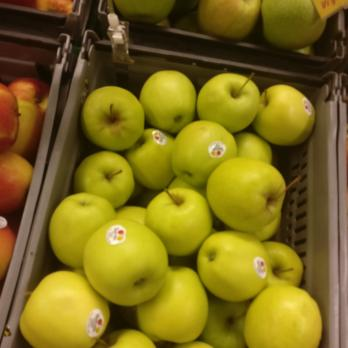

In [ ]:
image = load_image_data(df_images.iloc[8]["image_data"])
image

In [ ]:
# Observamos la representación matricial de cada imagen:
I = np.array(image)
print("Image shape", I.shape)
print(f"Image range in each coordinate: [{I.min()}, {I.max()}]")

Image shape (348, 348, 3)
Image range in each coordinate: [0, 255]




---



# 3. Preparación de datos y entrenamiento del modelo:

In [ ]:
# Montamos el google drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Preparar los datos:
class FruitDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = df['coarse_cat'].unique()
        self.label_map = {label: idx for idx, label in enumerate(self.labels)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = load_image_data(row["image_data"])
        label = self.label_map[row['coarse_cat']]

        if self.transform:
            image = self.transform(image)

        return image, label
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Crear subconjuntos de train, test y validation basados en la columna "dataset":
train_df = df_images[df_images["dataset"] == "train"]
test_df = df_images[df_images["dataset"] == "test"]
validation_df = df_images[df_images["dataset"] == "val"]

# Transformaciones de datos:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear los datasets:
train_dataset = FruitDataset(train_df, transform=transform)
test_dataset = FruitDataset(test_df, transform=transform)
validation_dataset = FruitDataset(validation_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
validation_loader = DataLoader(validation_dataset, batch_size=32)

In [ ]:
# Ruta para guardar el modelo en Google Drive:
model_save_path = '/content/drive/MyDrive/best_model.pth'

# Configurar el dispositivo:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Modificar ResNet para clasificación de frutas:
resnet = models.resnet152(pretrained=True)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, len(train_dataset.labels))  # Ajustar la última capa
resnet = resnet.to(device)

# Configurar el criterio de pérdida y el optimizador:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 144MB/s]


In [ ]:
# Entrenar el modelo y guardar el mejor modelo:
num_epochs = 25
best_accuracy = 0.0

# Listas para registrar las pérdidas y precisión
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

    # Evaluación en test:
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Guardar el modelo si mejora en precisión en Google Drive:
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(resnet.state_dict(), model_save_path)
        print("Mejor modelo guardado en Google Drive con una precisión de prueba de: {:.2f}%".format(best_accuracy))

print("Entrenamiento y evaluación completados.")

Epoch 1, Loss: 0.5737821507182989
Test Accuracy: 83.74%
Mejor modelo guardado en Google Drive con una precisión de prueba de: 83.74%
Epoch 2, Loss: 0.1698975930498405
Test Accuracy: 83.66%
Epoch 3, Loss: 0.20757340961559254
Test Accuracy: 85.40%
Mejor modelo guardado en Google Drive con una precisión de prueba de: 85.40%
Epoch 4, Loss: 0.18251186795532703
Test Accuracy: 89.18%
Mejor modelo guardado en Google Drive con una precisión de prueba de: 89.18%
Epoch 5, Loss: 0.21031452334401282
Test Accuracy: 89.33%
Mejor modelo guardado en Google Drive con una precisión de prueba de: 89.33%
Epoch 6, Loss: 0.18162114012309097
Test Accuracy: 86.61%
Epoch 7, Loss: 0.1621208874170076
Test Accuracy: 87.82%
Epoch 8, Loss: 0.08170910234647719
Test Accuracy: 88.20%
Epoch 9, Loss: 0.07127918072298846
Test Accuracy: 90.47%
Mejor modelo guardado en Google Drive con una precisión de prueba de: 90.47%
Epoch 10, Loss: 0.07572196507614783
Test Accuracy: 89.79%
Epoch 11, Loss: 0.11727233896751633
Test Accura

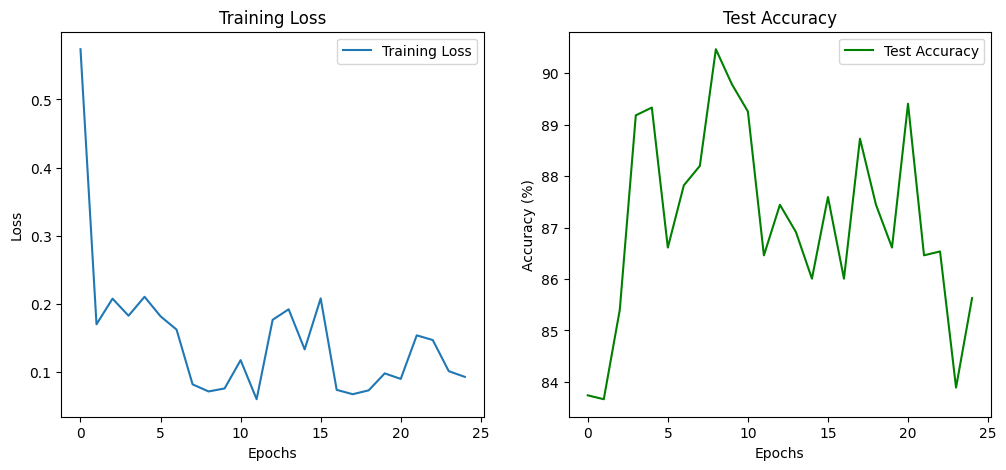

In [ ]:
# Visualización de la pérdida y precisión
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.show()


In [ ]:
# Cargar el mejor modelo guardado para hacer predicciones en el conjunto de validación:
best_model = models.resnet152(pretrained=True)
best_model.fc = nn.Linear(num_features, len(train_dataset.labels))  # Ajustar la última capa:
model_save_path = '/content/drive/MyDrive/best_model.pth'
best_model.load_state_dict(torch.load(model_save_path))
best_model = best_model.to(device)
best_model.eval()

# Evaluación en el conjunto de validación:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total:.2f}%")

<ipython-input-14-b79f4ad6f027>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(model_save_path))


Validation Accuracy: 85.96%




---



# Función de costos y predicción del conjunto de validación:

In [ ]:
# Definir los precios por clase:
prices = {
    'Apple': 74,
    'Pear': 89,
    'Satsumas': 44,
    'Melon': 109,
    'Orange': 35
}

# Convertir los precios a una lista ordenada:
price_list = [prices[label] for label in train_dataset.labels]

# Generar predicciones en el conjunto de validación y recolectar etiquetas reales y predichas:
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calcular la matriz de confusión:
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Función de cálculo de costo basado en Y_pred y Y_real:
def calculate_cost(y_real, y_pred):
    if y_pred > y_real:
        return 5 * (y_pred - y_real)
    elif y_pred < y_real:
        return y_real - y_pred
    else:
        return 0

# Calcular el costo total basado en las predicciones y etiquetas reales:
total_cost = 0
for real, pred in zip(all_labels, all_predictions):
    y_real_price = price_list[real]
    y_pred_price = price_list[pred]
    total_cost += calculate_cost(y_real_price, y_pred_price)

print(f"Costo Total: ${total_cost:.2f}")


Confusion Matrix:
 [[21  0  0  1  0]
 [ 2  3  0  0  0]
 [ 1  0  4  0  0]
 [ 2  0  0 18  0]
 [ 0  0  2  0  3]]
Costo Total: $515.00


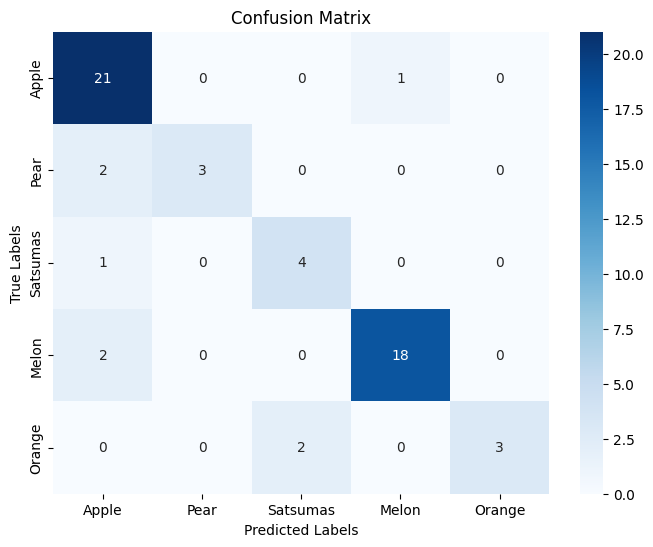

In [ ]:
import seaborn as sns

# Visualización de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.labels,
            yticklabels=train_dataset.labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Analizar cada elemento de la matriz de confusión y calcular el costo para corroborar errores:
costs = []

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix)):
        if conf_matrix[i, j] > 0:
            y_real_price = price_list[i]
            y_pred_price = price_list[j]
            cost = calculate_cost(y_real_price, y_pred_price)
            costs.append({
                'Real Class': train_dataset.labels[i],
                'Predicted Class': train_dataset.labels[j],
                'Occurrences': conf_matrix[i, j],
                'Cost per Occurrence': cost,
                'Total Cost': cost * conf_matrix[i, j]
            })

# Mostrar resultados detallados:
for entry in costs:
    print(entry)

# Calcular el costo total
total_cost = sum(entry['Total Cost'] for entry in costs)
print(f"\nCosto Total: ${total_cost:.2f}")

{'Real Class': 'Apple', 'Predicted Class': 'Apple', 'Occurrences': 21, 'Cost per Occurrence': 0, 'Total Cost': 0}
{'Real Class': 'Apple', 'Predicted Class': 'Melon', 'Occurrences': 1, 'Cost per Occurrence': 175, 'Total Cost': 175}
{'Real Class': 'Pear', 'Predicted Class': 'Apple', 'Occurrences': 2, 'Cost per Occurrence': 15, 'Total Cost': 30}
{'Real Class': 'Pear', 'Predicted Class': 'Pear', 'Occurrences': 3, 'Cost per Occurrence': 0, 'Total Cost': 0}
{'Real Class': 'Satsumas', 'Predicted Class': 'Apple', 'Occurrences': 1, 'Cost per Occurrence': 150, 'Total Cost': 150}
{'Real Class': 'Satsumas', 'Predicted Class': 'Satsumas', 'Occurrences': 4, 'Cost per Occurrence': 0, 'Total Cost': 0}
{'Real Class': 'Melon', 'Predicted Class': 'Apple', 'Occurrences': 2, 'Cost per Occurrence': 35, 'Total Cost': 70}
{'Real Class': 'Melon', 'Predicted Class': 'Melon', 'Occurrences': 18, 'Cost per Occurrence': 0, 'Total Cost': 0}
{'Real Class': 'Orange', 'Predicted Class': 'Satsumas', 'Occurrences': 2, 'C